Navigate to <code>/chest_xray_code/data</code> and run 
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz</code>
<code>wget https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz</code>

Then decompress them, and make sure they're in a directory called <code>/raw_reports</code> and <code>/xrays</code> respectively... (one of them decompresses to its own directory, so you need to rename that directory raw_reports instead of encgn or whatever).


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as T
import final_proj_code.chest_xray_code.src.preprocess_dataset as preprocess_dataset
import final_proj_code.chest_xray_code.src.utils as utils
import os
import torch.nn.functional as F


import numpy as np

Navigate to final_proj_code/chest_xray_code/src and run 

<code> python preprocess_dataset.py </code>

Now the data is stored in a numpy array in <code>../data/dataset.npy</code> 

In [ ]:
X, Y = utils.load_X_and_Y()
x_train, x_dev, x_test = X
y_train, y_dev, y_test = Y



In [16]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')

In [52]:
NUM_TRAIN = 100

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 150)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

images = {}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [18]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [19]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [28]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)

        
    i = 0
    for image in x:
        images[image] = scores[i]
        i += 1

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [40]:
def train_part34(model, optimizer, epochs=10):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_history = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)

            reconstruction = model(x)
            loss_function = nn.MSELoss(size_average=False)
            loss = loss_function(reconstruction, x)
            #i = 0
            #for image in x:
                #images[image] = reconstruction[i]
                #imshow_noax(image, normalize=False)
                #imshow_noax(reconstruction[i], normalize=False)
                #plt.imshow(image.detach().numpy().transpose(2,1,0))
                #plt.imshow(reconstruction[i].detach().numpy().transpose(2,1,0))
                #i += 1

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            loss_history.append(loss.item())

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                #check_accuracy_part34(loader_val, model)
                print()

# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [58]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
class TestConvNet(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_3_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_compress = nn.BatchNorm2d(size)
        self.relu_3_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_4_compress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_compress = nn.BatchNorm2d(size)
        self.relu_4_compress = nn.ReLU()
        
        
        
        self.conv_3 = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( 
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_3_compress,
            self.batchnorm_3_compress,
            self.relu_3_compress,
            
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_4_compress,
            self.batchnorm_4_compress,
            self.relu_4_compress,
            
            self.conv_3,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
        
            self.conv_10_decompress

            
        ).to(device)
        scores = model(x)
        return scores
    


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

channels = 3
size = 32

model = TestConvNet(channels, size)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
                     #momentum=0.9, nesterov=True)#optim.SGD(model.parameters(), lr=5e-3)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=100)

Iteration 0, loss = 81254.3125

Iteration 0, loss = 31068.1484

Iteration 0, loss = 18107.0195

Iteration 0, loss = 9895.1523

Iteration 0, loss = 8541.9014

Iteration 0, loss = 8415.9648

Iteration 0, loss = 7230.5811

Iteration 0, loss = 6231.4287

Iteration 0, loss = 6264.1948

Iteration 0, loss = 5836.0259

Iteration 0, loss = 5618.9312

Iteration 0, loss = 5077.5493

Iteration 0, loss = 5231.9380

Iteration 0, loss = 4872.4302

Iteration 0, loss = 4779.2983

Iteration 0, loss = 4888.8154

Iteration 0, loss = 4827.9146

Iteration 0, loss = 4536.1919

Iteration 0, loss = 4528.1572

Iteration 0, loss = 4455.4146

Iteration 0, loss = 4512.2876

Iteration 0, loss = 4258.6401

Iteration 0, loss = 4174.0283

Iteration 0, loss = 4267.4907

Iteration 0, loss = 3785.3850

Iteration 0, loss = 4200.5449

Iteration 0, loss = 4004.6870

Iteration 0, loss = 3660.9453

Iteration 0, loss = 3858.8801

Iteration 0, loss = 3643.9648

Iteration 0, loss = 3297.3425

Iteration 0, loss = 3468.9648

Itera

Checking accuracy on test set


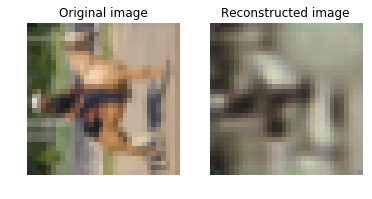

tensor([[[ 0.1255,  0.1725,  0.2431,  ...,  0.1490,  0.1373,  0.1451],
         [ 0.1059,  0.2039,  0.2314,  ...,  0.1451,  0.1569,  0.1647],
         [ 0.2157,  0.2431,  0.2314,  ...,  0.1490,  0.1137,  0.1725],
         ...,
         [ 0.7176,  0.7333,  0.7255,  ...,  0.6235,  0.6275,  0.7059],
         [ 0.7176,  0.7255,  0.7176,  ...,  0.7569,  0.7569,  0.7373],
         [ 0.6706,  0.6745,  0.6784,  ...,  0.7020,  0.7059,  0.6980]],

        [[ 0.1294,  0.2196,  0.2745,  ...,  0.2000,  0.1843,  0.1725],
         [ 0.1412,  0.2510,  0.2745,  ...,  0.2000,  0.2078,  0.1961],
         [ 0.2667,  0.2706,  0.2745,  ...,  0.2000,  0.1569,  0.1961],
         ...,
         [ 0.6353,  0.6549,  0.6549,  ...,  0.5373,  0.5451,  0.6157],
         [ 0.6275,  0.6471,  0.6392,  ...,  0.6667,  0.6627,  0.6392],
         [ 0.5412,  0.5686,  0.5647,  ...,  0.5804,  0.5804,  0.5569]],

        [[ 0.0863,  0.1176,  0.1725,  ...,  0.1412,  0.1333,  0.1216],
         [ 0.0784,  0.1412,  0.1608,  ...,  0

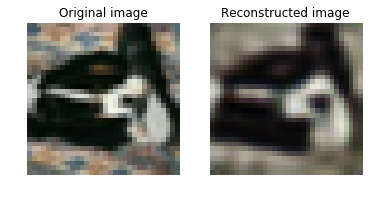

tensor([[[ 0.3255,  0.2627,  0.3647,  ...,  0.4000,  0.3922,  0.4078],
         [ 0.2980,  0.2471,  0.3608,  ...,  0.4078,  0.3412,  0.4235],
         [ 0.5137,  0.3255,  0.5608,  ...,  0.4824,  0.3255,  0.3804],
         ...,
         [ 0.3686,  0.4196,  0.6588,  ...,  0.2745,  0.2392,  0.2980],
         [ 0.3725,  0.4510,  0.5647,  ...,  0.2824,  0.2980,  0.3255],
         [ 0.3059,  0.3255,  0.3804,  ...,  0.3451,  0.2863,  0.2980]],

        [[ 0.3725,  0.3490,  0.4078,  ...,  0.3922,  0.4275,  0.4078],
         [ 0.3529,  0.3373,  0.4275,  ...,  0.3765,  0.3725,  0.4235],
         [ 0.5176,  0.3451,  0.5765,  ...,  0.4196,  0.3451,  0.3882],
         ...,
         [ 0.3765,  0.3725,  0.5725,  ...,  0.2902,  0.2392,  0.2549],
         [ 0.4392,  0.4667,  0.5176,  ...,  0.3216,  0.3255,  0.3255],
         [ 0.4275,  0.4235,  0.4196,  ...,  0.3843,  0.3373,  0.3686]],

        [[ 0.3569,  0.4157,  0.4196,  ...,  0.3451,  0.4118,  0.3647],
         [ 0.3412,  0.4039,  0.4588,  ...,  0

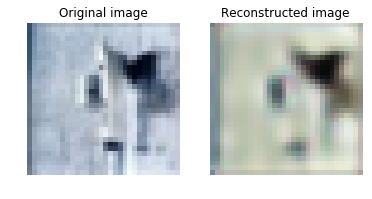

tensor([[[ 0.2275,  0.2235,  0.2039,  ...,  0.3725,  0.4039,  0.4431],
         [ 0.4510,  0.4667,  0.4471,  ...,  0.5804,  0.6157,  0.5922],
         [ 0.5529,  0.5882,  0.5765,  ...,  0.6510,  0.7020,  0.6902],
         ...,
         [ 0.7412,  0.8118,  0.7922,  ...,  0.7529,  0.7765,  0.8431],
         [ 0.6941,  0.7490,  0.7412,  ...,  0.7059,  0.7255,  0.8314],
         [ 0.6902,  0.7412,  0.7294,  ...,  0.7608,  0.7686,  0.8196]],

        [[ 0.2980,  0.2980,  0.2941,  ...,  0.4314,  0.4627,  0.4980],
         [ 0.5176,  0.5373,  0.5333,  ...,  0.6392,  0.6745,  0.6471],
         [ 0.6157,  0.6549,  0.6549,  ...,  0.7059,  0.7608,  0.7451],
         ...,
         [ 0.7922,  0.8588,  0.8392,  ...,  0.8000,  0.8235,  0.8863],
         [ 0.7412,  0.7922,  0.7843,  ...,  0.7451,  0.7647,  0.8667],
         [ 0.7255,  0.7765,  0.7647,  ...,  0.7922,  0.8000,  0.8471]],

        [[ 0.4039,  0.4157,  0.4157,  ...,  0.5059,  0.5373,  0.5686],
         [ 0.6157,  0.6431,  0.6471,  ...,  0

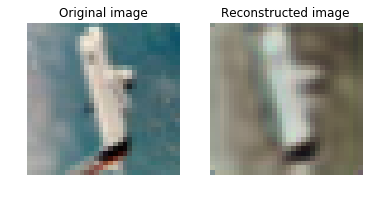

tensor([[[ 0.6078,  0.5961,  0.5451,  ...,  0.6863,  0.6745,  0.6510],
         [ 0.5882,  0.5882,  0.5529,  ...,  0.6863,  0.6627,  0.6353],
         [ 0.5922,  0.6039,  0.5569,  ...,  0.6706,  0.6471,  0.6118],
         ...,
         [ 0.1686,  0.1529,  0.1294,  ...,  0.3020,  0.2784,  0.3020],
         [ 0.1490,  0.0941,  0.0745,  ...,  0.3020,  0.2941,  0.3059],
         [ 0.2549,  0.1451,  0.0667,  ...,  0.2588,  0.3059,  0.3176]],

        [[ 0.6235,  0.6275,  0.5922,  ...,  0.6941,  0.6784,  0.6627],
         [ 0.6039,  0.6196,  0.5922,  ...,  0.6863,  0.6627,  0.6392],
         [ 0.6157,  0.6314,  0.5961,  ...,  0.6667,  0.6431,  0.6196],
         ...,
         [ 0.3843,  0.3804,  0.3686,  ...,  0.4314,  0.4392,  0.4706],
         [ 0.3647,  0.3373,  0.3412,  ...,  0.4431,  0.4549,  0.4627],
         [ 0.4510,  0.3804,  0.3373,  ...,  0.4118,  0.4549,  0.4588]],

        [[ 0.6588,  0.6549,  0.6157,  ...,  0.6745,  0.6588,  0.6510],
         [ 0.6235,  0.6353,  0.6039,  ...,  0

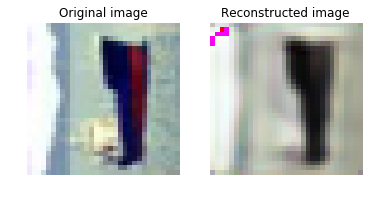

tensor([[[ 0.9922,  0.9725,  0.9451,  ...,  0.9647,  0.9373,  0.9412],
         [ 0.9922,  0.9922,  0.9843,  ...,  1.0000,  0.9804,  0.9725],
         [ 0.9765,  0.9765,  0.9804,  ...,  1.0000,  0.9843,  0.9529],
         ...,
         [ 0.7216,  0.7255,  0.6431,  ...,  0.6118,  0.5725,  0.5647],
         [ 0.6941,  0.7255,  0.6275,  ...,  0.5725,  0.5647,  0.5647],
         [ 0.6471,  0.6706,  0.5804,  ...,  0.5255,  0.6000,  0.5647]],

        [[ 0.9843,  0.9569,  0.9216,  ...,  0.9412,  0.9216,  0.9137],
         [ 0.9922,  0.9882,  0.9804,  ...,  0.9843,  0.9725,  0.9804],
         [ 0.9922,  0.9961,  1.0000,  ...,  0.9922,  0.9922,  0.9882],
         ...,
         [ 0.7451,  0.7608,  0.7059,  ...,  0.6863,  0.6353,  0.6000],
         [ 0.7176,  0.7608,  0.6980,  ...,  0.6471,  0.6235,  0.6000],
         [ 0.6745,  0.7098,  0.6549,  ...,  0.6039,  0.6588,  0.6000]],

        [[ 1.0000,  1.0000,  0.9961,  ...,  0.9961,  0.9843,  0.9843],
         [ 1.0000,  1.0000,  1.0000,  ...,  0

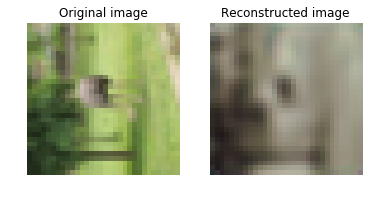

tensor([[[ 0.5333,  0.5333,  0.4902,  ...,  0.1216,  0.1333,  0.1294],
         [ 0.6471,  0.5922,  0.5059,  ...,  0.1294,  0.1294,  0.1255],
         [ 0.6824,  0.6471,  0.5216,  ...,  0.1529,  0.1294,  0.1255],
         ...,
         [ 0.6706,  0.6549,  0.7176,  ...,  0.6275,  0.6431,  0.5961],
         [ 0.6824,  0.6392,  0.6196,  ...,  0.6078,  0.6118,  0.6000],
         [ 0.7961,  0.7686,  0.6980,  ...,  0.6118,  0.6196,  0.6157]],

        [[ 0.5882,  0.6235,  0.5882,  ...,  0.1647,  0.1804,  0.1765],
         [ 0.6118,  0.6431,  0.5843,  ...,  0.1804,  0.1765,  0.1725],
         [ 0.6471,  0.6275,  0.5647,  ...,  0.2078,  0.1804,  0.1804],
         ...,
         [ 0.6314,  0.6314,  0.6980,  ...,  0.6980,  0.7020,  0.6784],
         [ 0.6588,  0.6078,  0.5922,  ...,  0.6902,  0.6824,  0.6863],
         [ 0.7765,  0.7216,  0.6588,  ...,  0.7020,  0.7059,  0.7020]],

        [[ 0.3569,  0.3804,  0.3608,  ...,  0.0941,  0.1098,  0.1020],
         [ 0.4784,  0.4588,  0.3647,  ...,  0

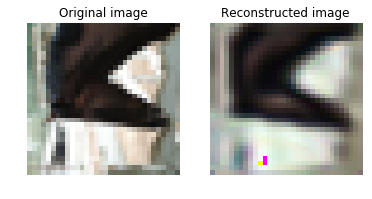

tensor([[[ 0.3294,  0.3843,  0.3882,  ...,  0.6980,  0.6510,  0.6275],
         [ 0.5569,  0.7333,  0.6706,  ...,  0.7451,  0.6902,  0.6980],
         [ 0.7098,  0.7451,  0.6941,  ...,  0.6863,  0.6627,  0.7098],
         ...,
         [ 0.0667,  0.0471,  0.0863,  ...,  0.4471,  0.4588,  0.4510],
         [ 0.0314,  0.1098,  0.3569,  ...,  0.4824,  0.4314,  0.4471],
         [ 0.1725,  0.4078,  0.5373,  ...,  0.5529,  0.4980,  0.3333]],

        [[ 0.4706,  0.4902,  0.4902,  ...,  0.7451,  0.6627,  0.6667],
         [ 0.6196,  0.7137,  0.6588,  ...,  0.7843,  0.6941,  0.7255],
         [ 0.7529,  0.7686,  0.7255,  ...,  0.7216,  0.6627,  0.7294],
         ...,
         [ 0.0627,  0.0431,  0.0745,  ...,  0.4627,  0.4706,  0.4902],
         [ 0.0353,  0.0863,  0.3255,  ...,  0.5020,  0.4431,  0.4824],
         [ 0.1490,  0.3804,  0.5569,  ...,  0.5804,  0.5176,  0.3529]],

        [[ 0.3843,  0.4039,  0.4118,  ...,  0.6627,  0.5961,  0.5686],
         [ 0.5686,  0.6667,  0.6000,  ...,  0

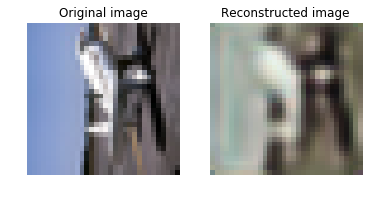

tensor([[[ 0.4471,  0.4510,  0.4549,  ...,  0.4706,  0.4706,  0.4667],
         [ 0.4627,  0.4667,  0.4706,  ...,  0.4863,  0.4863,  0.4863],
         [ 0.4784,  0.4824,  0.4863,  ...,  0.5059,  0.5059,  0.5059],
         ...,
         [ 0.3765,  0.3725,  0.3843,  ...,  0.3294,  0.3373,  0.3569],
         [ 0.4431,  0.4667,  0.4667,  ...,  0.3216,  0.3020,  0.2549],
         [ 0.4235,  0.4157,  0.4118,  ...,  0.3216,  0.2000,  0.0431]],

        [[ 0.5569,  0.5608,  0.5647,  ...,  0.5765,  0.5765,  0.5725],
         [ 0.5686,  0.5725,  0.5725,  ...,  0.5882,  0.5843,  0.5843],
         [ 0.5765,  0.5843,  0.5843,  ...,  0.5961,  0.5961,  0.5922],
         ...,
         [ 0.3490,  0.3451,  0.3529,  ...,  0.2941,  0.3020,  0.3255],
         [ 0.4196,  0.4392,  0.4275,  ...,  0.2902,  0.2784,  0.2353],
         [ 0.4000,  0.3882,  0.3725,  ...,  0.2980,  0.1843,  0.0314]],

        [[ 0.7725,  0.7725,  0.7804,  ...,  0.7882,  0.7882,  0.7843],
         [ 0.7765,  0.7804,  0.7882,  ...,  0

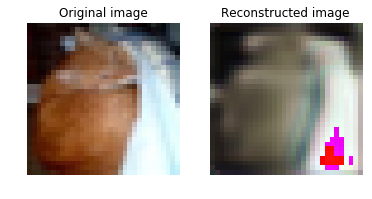

tensor([[[ 0.0667,  0.0902,  0.1098,  ...,  0.1804,  0.1922,  0.1961],
         [ 0.0510,  0.0588,  0.0667,  ...,  0.2314,  0.2275,  0.2078],
         [ 0.0902,  0.0627,  0.0549,  ...,  0.2471,  0.2353,  0.2078],
         ...,
         [ 0.1098,  0.1098,  0.1216,  ...,  0.8588,  0.8627,  0.8784],
         [ 0.2118,  0.2196,  0.2353,  ...,  0.7804,  0.7451,  0.7451],
         [ 0.2118,  0.2196,  0.2431,  ...,  0.8392,  0.7843,  0.7725]],

        [[ 0.0118,  0.0078,  0.0039,  ...,  0.1137,  0.1333,  0.1216],
         [ 0.0196,  0.0039,  0.0000,  ...,  0.1373,  0.1569,  0.1490],
         [ 0.0588,  0.0196,  0.0039,  ...,  0.1020,  0.1412,  0.1490],
         ...,
         [ 0.1451,  0.1451,  0.1529,  ...,  0.9804,  0.9843,  0.9843],
         [ 0.2667,  0.2706,  0.2902,  ...,  0.9294,  0.9216,  0.9255],
         [ 0.2863,  0.2902,  0.3059,  ...,  0.9843,  0.9569,  0.9373]],

        [[ 0.0118,  0.0118,  0.0118,  ...,  0.0471,  0.0667,  0.0510],
         [ 0.0157,  0.0039,  0.0039,  ...,  0

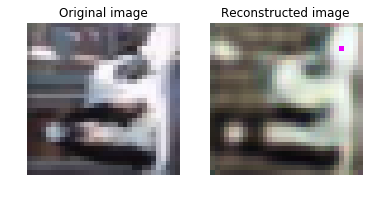

tensor([[[ 0.3725,  0.3647,  0.3765,  ...,  0.3137,  0.2784,  0.2039],
         [ 0.4039,  0.4078,  0.4784,  ...,  0.3490,  0.3020,  0.2157],
         [ 0.4667,  0.4667,  0.5098,  ...,  0.3765,  0.3176,  0.2275],
         ...,
         [ 0.8745,  0.9569,  0.9804,  ...,  0.3608,  0.2706,  0.3529],
         [ 0.8627,  0.8980,  0.9098,  ...,  0.2549,  0.2471,  0.2549],
         [ 0.8118,  0.8235,  0.8353,  ...,  0.2275,  0.2078,  0.2118]],

        [[ 0.3843,  0.3608,  0.3490,  ...,  0.3137,  0.2706,  0.1804],
         [ 0.4000,  0.3961,  0.4471,  ...,  0.3451,  0.2941,  0.1961],
         [ 0.4510,  0.4431,  0.4745,  ...,  0.3725,  0.3098,  0.2078],
         ...,
         [ 0.8706,  0.9412,  0.9490,  ...,  0.3804,  0.2902,  0.3725],
         [ 0.8588,  0.8824,  0.8784,  ...,  0.2588,  0.2510,  0.2588],
         [ 0.8039,  0.8118,  0.8078,  ...,  0.2196,  0.2000,  0.2039]],

        [[ 0.3608,  0.3529,  0.3608,  ...,  0.3333,  0.3059,  0.2157],
         [ 0.3765,  0.3804,  0.4510,  ...,  0

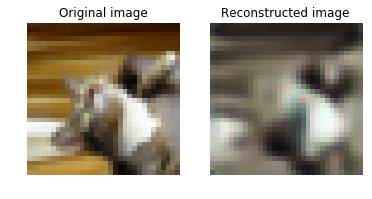

tensor([[[ 0.2667,  0.2157,  0.3176,  ...,  0.5412,  0.6118,  0.6863],
         [ 0.2745,  0.2275,  0.3255,  ...,  0.5373,  0.6431,  0.6902],
         [ 0.2706,  0.2431,  0.3176,  ...,  0.5569,  0.6824,  0.7020],
         ...,
         [ 0.1765,  0.1961,  0.2706,  ...,  0.3059,  0.4549,  0.4353],
         [ 0.1686,  0.2000,  0.2627,  ...,  0.5176,  0.5216,  0.4000],
         [ 0.1647,  0.2000,  0.2588,  ...,  0.4941,  0.3765,  0.2980]],

        [[ 0.1725,  0.1059,  0.1804,  ...,  0.4275,  0.4863,  0.5529],
         [ 0.1686,  0.1098,  0.1765,  ...,  0.4235,  0.5176,  0.5490],
         [ 0.1569,  0.1137,  0.1608,  ...,  0.4353,  0.5490,  0.5529],
         ...,
         [ 0.0706,  0.0784,  0.1294,  ...,  0.2667,  0.4078,  0.3843],
         [ 0.0667,  0.0824,  0.1255,  ...,  0.4627,  0.4627,  0.3529],
         [ 0.0588,  0.0824,  0.1255,  ...,  0.4392,  0.3333,  0.2706]],

        [[ 0.0510,  0.0039,  0.0431,  ...,  0.2353,  0.2235,  0.2549],
         [ 0.0471,  0.0039,  0.0353,  ...,  0

In [59]:



check_accuracy_part34(loader_test, model)


reconstruction = scores
i = 0
for original,reconstruction in images.items():
    if i < 11:
        plt.figure()
        org = original.detach().numpy().transpose(2,1,0)
        plt.subplot(1, 2, 1)
        imshow_noax(original.detach().numpy().transpose(2,1,0), normalize=False)
        plt.title('Original image')
        plt.subplot(1, 2, 2)
        rec = reconstruction.detach().numpy().transpose(2,1,0)
        imshow_noax(reconstruction.detach().numpy().transpose(2,1,0), normalize=False)
        plt.title('Reconstructed image')
        plt.show()
        print(original)
        print(reconstruction)
        print(((org - rec) ** 2).sum(axis=None))
        i += 1
    else: 
        break



In [46]:
print(((org - rec) ** 2).sum(axis=None))

91.96301
